# E-commerce Data 

The data is from a kaggle competition, you can find it here : https://www.kaggle.com/carrie1/ecommerce-data/kernels 


## Data cleaning 

Load the data and show the first rows to see how it looks like. 

In [308]:
import pandas as pd
df = pd.read_csv("ecommerce-data.csv", encoding="ISO-8859-1")
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


See if the data contains missing information. 

In [103]:
#Check missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Description and CustomerID have empty values. So, the following strategies are applied to resolve each case.  
- For the description, fill NAs values with an empty string.  
- For the CostomerID, as it is an identifier remove those rows. 

In [309]:
df['Description'].fillna('', inplace=True)
df.dropna(0, inplace=True)

If the Invoice number starts with 'C' means that corresponds to a cancellation. So, if we count the number of cancellations, we can see that there are many cancellations.   


In [280]:
df[df['InvoiceNo'].str.startswith('C')]['InvoiceNo'].count()

8905

So, we can add column to have the information if it is cancelled or not.

In [310]:
#add column cancelled
df['cancelled'] = df['InvoiceNo'].str.startswith('C').astype('int32')
df['cancelled'].unique()

array([0, 1])

## Data exploration
We can see different how many cancellations there are per:  
    - stockcode: how many cancellations per stockcode and how many items of this stockcode where cancelled. 
    - customer: how many cancellations the customer has
    - per country: how many cancellations each country has 

In [107]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'cancelled'],
      dtype='object')

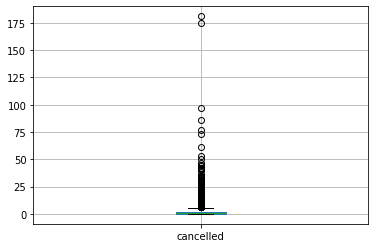

In [108]:
# amount of cancellations per stock
import numpy as np
per_stockcode = df[['StockCode','cancelled','Quantity']].groupby(['StockCode']).sum().reset_index()
per_stockcode.boxplot(column=['cancelled'])

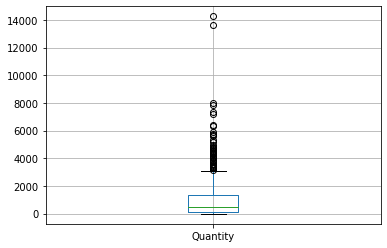

In [8]:
# amount of items of each stockcode where cancelled 
cancelled_per_stockcode = per_stockcode[per_stockcode['cancelled']==1]
cancelled_per_stockcode.boxplot(column=['Quantity'])

From the graphs we can see that there are two products are cancelled more times. 

In [9]:
#print outliers
per_stockcode[per_stockcode['cancelled']>170]

,StockCode,cancelled,Quantity
1292,22423,181,11555
3681,M,175,3184


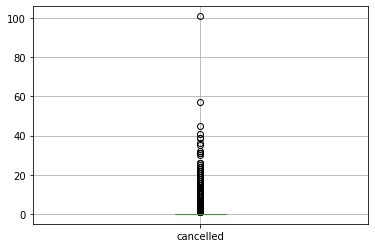

In [10]:
# cancellations per customer. 
per_client = df[['CustomerID','InvoiceNo','cancelled']].groupby(['CustomerID','InvoiceNo']).sum().reset_index()
per_client.boxplot(column=['cancelled'])

From the graph, we can see that there is an outlier, a customer that cancelled more than 100 orders.  

In [11]:
#print outlier 
per_client[per_client['cancelled']>100]

,CustomerID,InvoiceNo,cancelled
1004,12607.0,C570867,101


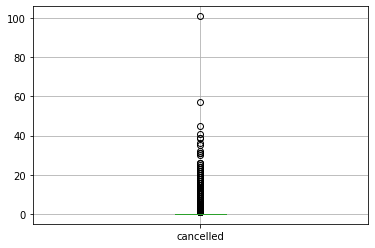

In [12]:
# cancellations per customer. 
per_country = df[['Country','InvoiceNo','cancelled']].groupby(['Country','InvoiceNo']).sum().reset_index()
per_country.boxplot(column=['cancelled'])

There is a country that is outlier 

In [13]:
#print outlier 
per_country[per_country['cancelled']>100]

,Country,InvoiceNo,cancelled
2320,USA,C570867,101


### Cancellations

We can see the cancellations among countries. In order to do this, we can merge with a dataset that contains the location for each country, and in this way create a world map to visualize it.

In [14]:
#plot countries
import geopandas
from matplotlib import cm

def plot_countries(df, title, country_column_name, column_name, legend=False):
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    merged_inner = pd.merge(left=world, right=df, left_on='name',right_on=country_column_name, how='inner')
    cmap = cm.get_cmap('Spectral')
    ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
    ax.set_title(title)
    merged_inner.plot(column=column_name, ax=ax, cmap=cmap, legend=legend)


In [15]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = per_country[['Country','cancelled']].groupby(['Country']).sum().reset_index()
world_values = world['name'].values
countries['is_in'] = np.array([x in world_values for x in countries['Country']])
print(countries[countries['is_in']==False])

               Country  cancelled  is_in
2              Bahrain          0  False
6      Channel Islands         10  False
8       Czech Republic          5  False
10                EIRE        247  False
11  European Community          1  False
22               Malta         15  False
27                 RSA          0  False
29           Singapore          7  False
33                 USA        112  False
36         Unspecified          0  False


In [16]:
#edit countries names according to world dataset
def map_countries(countries):
    countries[countries['Country']=='USA']['Country'] = 'United States of America'
    countries[countries['Country']=='RSA']['Country'] = 'South Africa'
    countries[countries['Country']=='Czech Republic']['Country'] = 'Czechia'
    countries[countries['Country']=='EIRE']['Country'] = 'Ireland'
    return countries

countries = map_countries(countries)

#create is_in column to keep countries that are in world dataset
countries['is_in'] = np.array([x in world_values for x in countries['Country']])
countries = countries[countries['is_in']] 
countries.drop(columns=['is_in'], axis=1, inplace=True)
countries

/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be 

,Country,cancelled
0,Australia,74
1,Austria,3
3,Belgium,38
4,Brazil,0
5,Canada,0
7,Cyprus,8
9,Denmark,9
12,Finland,10
13,France,149
14,Germany,453


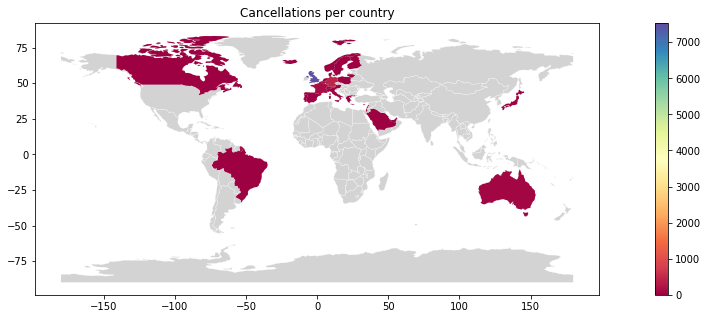

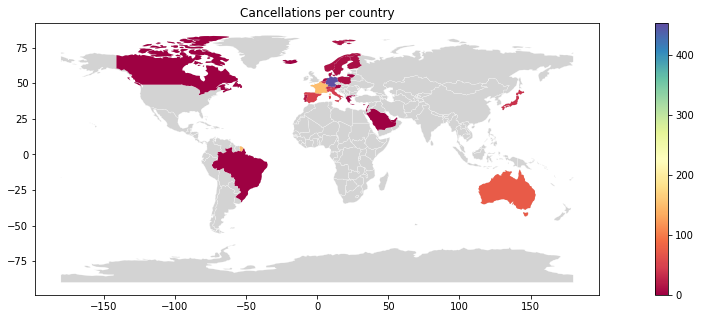

In [17]:
#plot cancelletions per countries into the map
plot_countries(countries, 'Cancellations per country', 'Country', 'cancelled', True)

#without United Kingdom since it has a lot of cancellations and it might be the outlier that we saw in the other graph
plot_countries(countries[countries['Country'] != 'United Kingdom'], 'Cancellations per country', 'Country', 'cancelled', True)

### Sales

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 <a list of 36 Text xticklabel objects>)

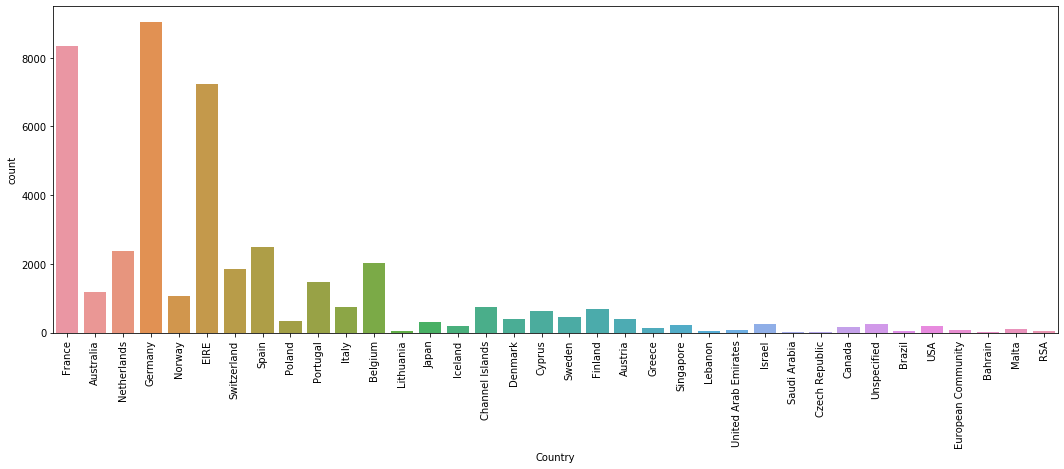

In [18]:
#Visualize the amount of sales per country, removing United Kingdom since it has a lot of sales 
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))
sns.countplot(df[(df['Country'] != 'United Kingdom') & (df['cancelled']==0)]['Country'])
plt.xticks(rotation=90)

### Products

See the top 10 products for each country

In [109]:
products = df[['StockCode', 'Country', 'Quantity']].groupby(['StockCode', 'Country']).sum().reset_index()

In [110]:
products[products['Country']=='United Kingdom']

,StockCode,Country,Quantity
6,10002,United Kingdom,401
7,10080,United Kingdom,291
9,10120,United Kingdom,183
10,10123C,United Kingdom,5
11,10124A,United Kingdom,16
...,...,...,...
18939,D,United Kingdom,-1191
18940,DOT,United Kingdom,16
18956,M,United Kingdom,3681
18957,PADS,United Kingdom,4


In [111]:
def get_top_n(df, col, col_sort, n): 
    df_ret = pd.DataFrame()
    for i in df[col].unique():
        df_aux = df[df[col]==i].sort_values(col_sort, ascending=False).reset_index()
        df_aux = df_aux[0:n]
        df_ret = df_ret.append(df_aux)
    return df_ret

#for each country keep top 10
products = get_top_n(products, 'Country', 'Quantity', 10)

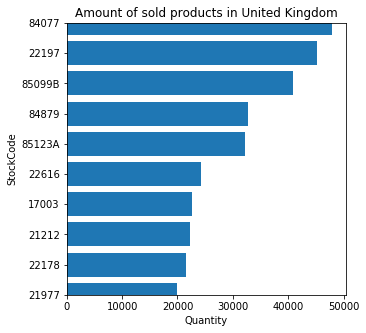

In [112]:
def plot_filter_bar(df, filter_col, col_bar, col_per, filter_value, n, title):
    filter_df = df[df[filter_col]==filter_value]
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.invert_yaxis()
    ax.barh(y=filter_df.index, width=col_bar, data=filter_df)
    ax.set_yticks(range(0,10))
    ax.set_yticklabels(filter_df[col_per].tolist())
    ax.set_ylabel(col_per)        
    ax.set_xlabel(col_bar)      
    ax.set_title(title)    
    plt.show()

plot_filter_bar(products, 'Country', 'Quantity', 'StockCode', 
                'United Kingdom', 10, 'Amount of sold products in United Kingdom')


See the most cancelled products for each country

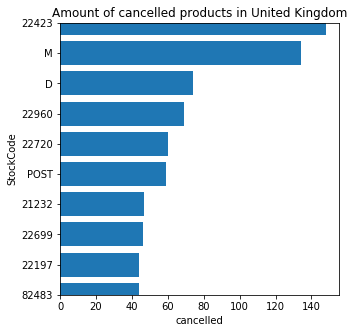

In [117]:
df['cancelled'] = df['InvoiceNo'].str.startswith('C').astype('int32')
cancelled_products = df[['StockCode', 'Country', 'cancelled']].groupby(['StockCode', 'Country']).sum().reset_index()
cancelled_products = get_top_n(cancelled_products, 'Country', 'cancelled', 10)
plot_filter_bar(cancelled_products, 'Country', 'cancelled', 'StockCode', 
                'United Kingdom', 10, 'Amount of cancelled products in United Kingdom')

## Clustering
   
**Clustering with K-means**   
Now, the idea is to find some type of clustering to see if there is any pattern in the data that might provide some insigths.  

First, clean the data to prepare for the analysis. 
Then, define the amount of clusters by applying the elbow test
Finally, apply k-means and get the labels assigned
Once we have the labels we have to analyze the results 


### Countries

In [19]:
# create year, month columns from the date 
df['year'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y')
df['month'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%m')
df['sales'] = df['Quantity']*df['UnitPrice']
df = map_countries(df)

/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be 

In [20]:
#drop unnecessary columns
df_aux = df.drop(['Description','InvoiceNo','InvoiceDate','UnitPrice','CustomerID'], axis=1, inplace=False)

#group by some columns and take the sum 
df_aux = df_aux.groupby(['StockCode','year','month', 'Country']).sum().reset_index()

# transform StockCode to integers
df_aux['StockCode'] = df_aux['StockCode'].astype('category').cat.codes
df_aux

,StockCode,year,month,Country,Quantity,cancelled,sales
0,0,2010,12,EIRE,12,0,10.20
1,0,2010,12,France,96,0,81.60
2,0,2010,12,United Kingdom,116,0,98.60
3,0,2011,01,France,156,0,132.60
4,0,2011,01,Germany,1,0,0.85
...,...,...,...,...,...,...,...
62470,3683,2011,12,Greece,3,0,135.00
62471,3683,2011,12,Norway,1,0,40.00
62472,3683,2011,12,Portugal,14,0,392.00
62473,3683,2011,12,Spain,1,0,28.00


Scale the data 

In [21]:
# study clusters without United Kingdom
from sklearn.preprocessing import scale
df_aux_1 = df_aux[df_aux['Country']!='United Kingdom'].copy()

x = df_aux_1.drop(['Country'],axis=1)
x = scale(x)

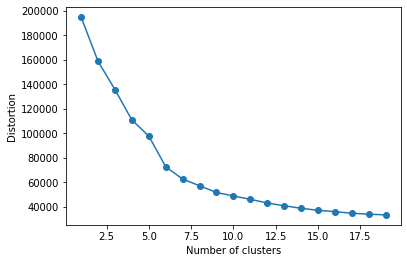

7


In [22]:
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator

def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee

n_clusters = elbow_test(x, 10, 20, 300)
print(n_clusters)

In [23]:
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
df_aux_1['cluster'] = km.labels_

Plot the clusters into the map to see if there is a relationship with the countries. 

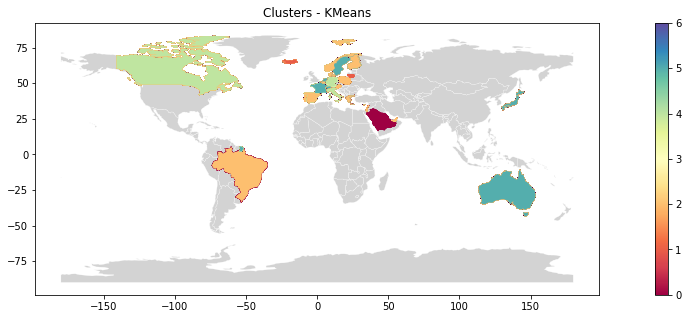

In [24]:
plot_countries(df_aux_1, 'Clusters - KMeans', 'Country', 'cluster', True)

We can plot a scatter plot for two of the variables and see how the relationship between them has influence in the division of the clusters

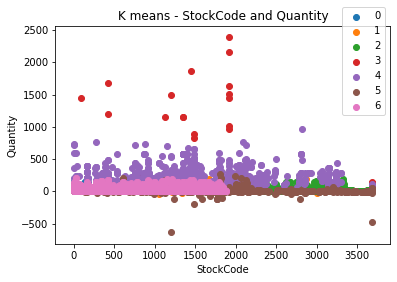

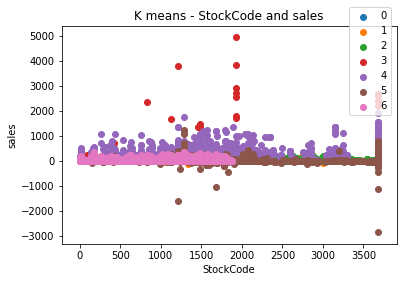

In [25]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
    
    ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()

draw_scatter(df_aux_1, 'StockCode', 'Quantity', 'cluster', n_clusters, 'K means - StockCode and Quantity')
draw_scatter(df_aux_1, 'StockCode', 'sales', 'cluster', n_clusters, 'K means - StockCode and sales')

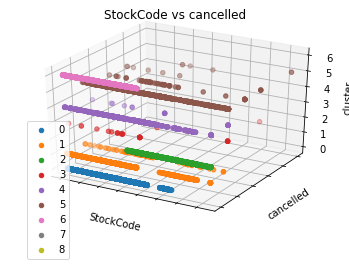

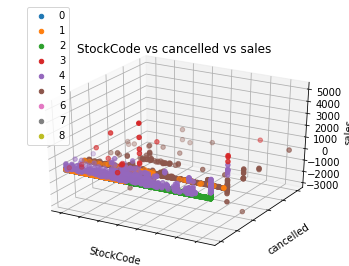

In [267]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

create_3d_scatter(df_aux_1, 'StockCode', 'cancelled', 'cluster', 'cluster', n_clusters, 'StockCode vs cancelled')
create_3d_scatter(df_aux_1, 'StockCode', 'cancelled', 'sales', 'cluster', n_clusters, 'StockCode vs cancelled vs sales')


### Customers

In [37]:
#see who bought more for each product 
products = df[['StockCode', 'CustomerID', 'sales']].groupby(['StockCode', 'CustomerID']).count().reset_index()

# for each product keep top 10 sales
products_df = pd.DataFrame()
for p in products['StockCode'].unique():
    p_df = products[products['StockCode']==p].sort_values('sales', ascending=False).reset_index()
    p_df = p_df[0:10]
    products_df = products_df.append(p_df)

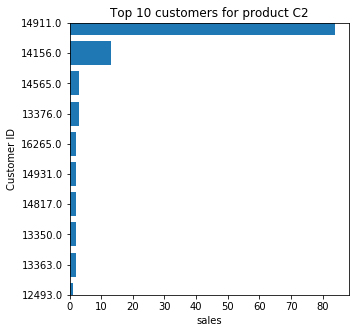

In [38]:
def plot_sales_per_customer(df, stockCode):
    stock_product = df[df['StockCode']==stockCode]
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.invert_yaxis()
    ax.barh(y=stock_product.index, width='sales', data=stock_product)
    ax.set_yticks(range(0,10))
    ax.set_yticklabels(stock_product['CustomerID'].tolist())
    ax.set_ylabel('Customer ID')        
    ax.set_xlabel('sales')      
    ax.set_title("Top 10 customers for product " + stockCode)    
    plt.show()

plot_sales_per_customer(products_df, 'C2')

Keep information relevant for each customer:
- total amount of purchases
- start date
- how many different products the customer bought
- total money spent
- last date purchase

In [253]:
#total amount of purchases
customers = df[df['cancelled']==0][['InvoiceNo','CustomerID']]
customers = customers.groupby(['CustomerID']).count().reset_index()
customers.rename(columns={'InvoiceNo':'total_purchases'}, inplace=True)

In [254]:
#start date
aux = df.copy()
aux = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).min().reset_index()
aux['start_year'] = aux['InvoiceDate'].dt.strftime('%Y')
aux['start_month'] = aux['InvoiceDate'].dt.strftime('%m')
aux['start_day'] = aux['InvoiceDate'].dt.strftime('%d')
aux['start_hour'] = aux['InvoiceDate'].dt.strftime('%H')
aux.drop(['InvoiceDate'], axis=1, inplace=True)
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
print(customers.isnull().sum())
customers.fillna(0, inplace=True)

CustomerID          0
total_purchases    33
start_year          0
start_month         0
start_day           0
start_hour          0
dtype: int64


In [255]:
#how many different products the customer bought
aux = df[['CustomerID','StockCode']].groupby(['CustomerID']).count().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
customers.rename(columns={'StockCode':'Products'}, inplace=True)

In [256]:
#total money spent
aux = df.copy()
aux['spent'] = aux['Quantity']*aux['UnitPrice']
aux = aux[['CustomerID','spent']].groupby(['CustomerID']).sum().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
customers.rename(columns={'StockCode':'Products'}, inplace=True)
customers['spent'] = customers['spent'].apply(lambda x: x if x>0 else 0)

In [257]:
#last date purchase
aux = df.copy()
aux = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).max().reset_index()
aux['last_year'] = aux['InvoiceDate'].dt.strftime('%Y')
aux['last_month'] = aux['InvoiceDate'].dt.strftime('%m')
aux['last_day'] = aux['InvoiceDate'].dt.strftime('%d')
aux['last_hour'] = aux['InvoiceDate'].dt.strftime('%H')
aux.drop(['InvoiceDate'], axis=1, inplace=True)
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
print(customers.isnull().sum())
customers.fillna(0, inplace=True)

CustomerID         0
total_purchases    0
start_year         0
start_month        0
start_day          0
start_hour         0
Products           0
spent              0
last_year          0
last_month         0
last_day           0
last_hour          0
dtype: int64


In [263]:
customers.columns

Index(['CustomerID', 'total_purchases', 'start_year', 'start_month',
       'start_day', 'start_hour', 'Products', 'spent', 'last_year',
       'last_month', 'last_day', 'last_hour', 'cluster'],
      dtype='object')

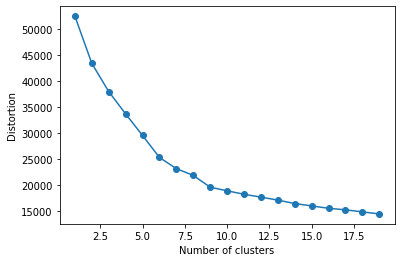

number of clusters: 9


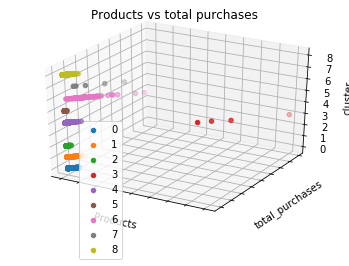

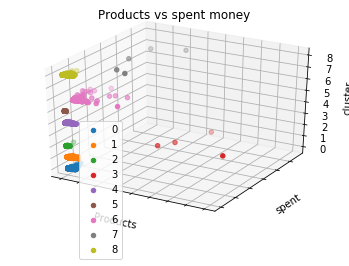

In [268]:
##apply k-means 
x = customers.drop(['CustomerID'],axis=1)
x = scale(x)
n_clusters = elbow_test(x, 10, 20, 300)
print('number of clusters:',n_clusters)
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
customers['cluster'] = km.labels_

#clients who made similar amount of purchases, buy similar products
create_3d_scatter(customers, 'Products', 'total_purchases', 'cluster', 'cluster', n_clusters, 'Products vs total purchases')

#while cluster 3 is more spread, generally the clients buy the same kind of products. Cluster 3 is the only one that has clients who spent more money 
create_3d_scatter(customers, 'Products', 'spent', 'cluster', 'cluster', n_clusters, 'Products vs spent money')

## Prediction
 Now we are goin to make a prediction of the sales for the sales in general
 

In [27]:
# keep columns of interest 
df_aux_2 = df_aux.copy()
df_aux_2 = df_aux_2[df_aux_2['cancelled']==0]
df_aux_2 = df_aux_2[df_aux_2['Country']!='United Kingdom']

#transform country column
df_aux_2['Country'] = df_aux_2['Country'].astype('category').cat.codes.astype('int32')

#remove columns that are not necessary. Remove year because the data is only for 2011 
df_aux_2 = df_aux_2.drop(columns=['StockCode', 'cancelled', 'Quantity'],axis=1)

#group by year and month and calculate the total sales per each month 
df_aux_2 = df_aux_2.groupby(['month','year']).sum() 

#create prev sales column - corresponding to previuos month's sales 
df_aux_2 = df_aux_2.sort_values(by=['month','year','Country']).reset_index()
df_aux_2['prev_sales'] = df_aux_2['sales'].shift(1)
df_aux_2.dropna(inplace=True)
expected_value = df_aux_2.tail(1)
df_aux_2.drop(expected_value.index, axis=0, inplace=True)
df_aux_2

,month,year,Country,sales,prev_sales
1,02,2011,26993,87232.78,120444.16
2,03,2011,33598,119630.05,87232.78
3,04,2011,23620,48968.65,119630.05
4,05,2011,32771,116852.12,48968.65
5,06,2011,37488,131674.42,116852.12
6,07,2011,38002,108475.12,131674.42
7,08,2011,47179,136633.82,108475.12
8,09,2011,46416,146676.64,136633.82
9,10,2011,66089,184960.76,146676.64
10,11,2011,57872,159427.49,184960.76


Score: 0.9225959965367216


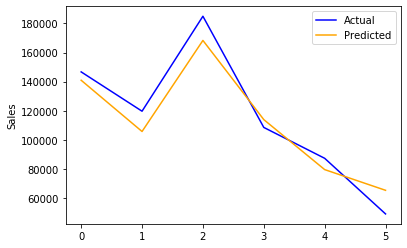

12    44312.86
Name: sales, dtype: float64 [86338.8996]


In [28]:
from sklearn import model_selection
from sklearn import linear_model

#split data into training and validation sets
X = df_aux_2.drop(['sales'], axis=1)
y = df_aux_2['sales']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.50, random_state=20)

#fit the model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators = 200, random_state = 100)
rf_model = rf_model.fit(X_test, y_test)

#make the predictions
predictions = rf_model.predict(X_test)
print('Score:',rf_model.score(X_test,y_test))
fig, ax = plt.subplots()

#plot actual vs predicted values 
ax.plot(y_test.to_numpy(), color = 'blue')
ax.plot(predictions, color = 'orange')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Sales')
plt.show()



#predict sales for next month
x = expected_value.drop(['sales'], axis=1)
x = rf_model.predict(x)
print(expected_value['sales'], x)
#If we have had more data, the prediction would be more accurate 

## Classification

The idea is to classify the sales according to the ranges in sales variable. Identifying as lost, low, medium and high sales. 

In [29]:
df_aux_3 = df.copy()
df_aux_3['sales_level'] = pd.cut(df_aux_3['sales'], bins=[df_aux_3['sales'].min()-1,0,df_aux_3['sales'].mean()/2,df_aux_3['sales'].mean(),df['sales'].max()], labels=[1,2,3, 4])

In [30]:
#transform country column
df_aux_3['Country'] = df_aux_3['Country'].astype('category').cat.codes.astype('int32')
df_aux_3['StockCode'] = df_aux_3['StockCode'].astype('category').cat.codes.astype('int32')
df_aux_3['InvoiceNo'] = df_aux_3['InvoiceNo'].astype('category').cat.codes.astype('int32')

In [31]:
df_aux_3.drop(['sales', 'Description', 'InvoiceDate'], axis=1, inplace=True)

In [32]:
#split the dataframe: X - predictors and y - target
X = df_aux_3.drop('sales_level', axis=1)
y = df_aux_3['sales_level']

#split dataset into test/train 
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=20)

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=202)
clf.fit(X_train, y_train)
print('Score:',clf.score(X_test, y_test))
predictions = clf.predict(X_test)
df_p = pd.DataFrame()
df_p['Actual'] = y_test
df_p['Predicted'] = predictions
df_p.head()

Score: 0.9996927463559718


,Actual,Predicted
380896,2,2
64508,2,2
365434,4,4
168943,2,2
475420,2,2


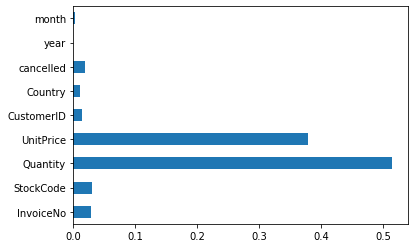

In [39]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
fig, ax = plt.subplots(1,1)
feat_importances.plot(kind='barh', ax=ax)
plt.show()

## Recommender System

The idea is to create a recommender system that is able to find possible products that the client might would like to buy. 




In [549]:
aux = df.copy()

#antiquity
aux['InvoiceDate'] = pd.to_datetime(aux['InvoiceDate'])
customers = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).min().reset_index()
customers['InvoiceDate'] = customers['InvoiceDate'].apply(lambda x: (pd.datetime.now() - x).days)
customers.rename(columns={'InvoiceDate':'antiquity'}, inplace=True)

#times purchased, times cancelled
aux = aux[['CustomerID','StockCode','Quantity','cancelled']].groupby(['CustomerID', 'StockCode']).sum().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')


In [550]:
#choose user: 12349.0
customer_id = 12349.0
customer = customers[customers['CustomerID']==customer_id]
customers = customers[customers['CustomerID']!=customer_id]
customer

,CustomerID,antiquity,StockCode,Quantity,cancelled
126,12349.0,3021,20685,6,0
127,12349.0,3021,20914,6,0
128,12349.0,3021,21086,12,0
129,12349.0,3021,21136,16,0
130,12349.0,3021,21231,36,0
...,...,...,...,...,...
194,12349.0,3021,84978,12,0
195,12349.0,3021,85014A,3,0
196,12349.0,3021,85014B,3,0
197,12349.0,3021,85053,6,0


In [552]:
from sklearn.preprocessing import scale
x = customers.drop(['CustomerID'],axis=1)
customers['StockCode'] = customers['StockCode'].astype('category').cat.codes
x = scale(x)

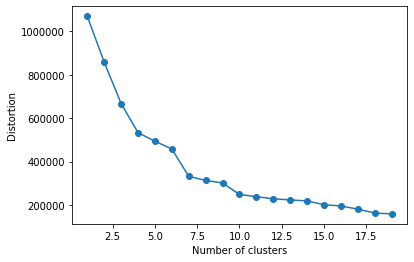

7


In [553]:
n_clusters = elbow_test(x, 10, 20, 300)
print(n_clusters)
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
customers['cluster'] = km.labels_

In [554]:
customer['StockCode'] = customer['StockCode'].astype('category').cat.codes
y = km.predict(scale(customer.drop(['CustomerID'],axis=1)))
print(customer.shape, y.shape)

(73, 5) (73,)


In [555]:
customer['cluster'] = y

In [560]:
#TODO: get stockcodes from clusters and choose one that the customer did not bought 
clusters = customer['cluster'].unique()
customers[customers['cluster'] in clusters]

/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Lengths must match to compare

In [570]:
customers_in_clusters = customers[customers['cluster'].apply(lambda x: True if x in clusters else False)]
products_in_clusters = customers_in_clusters['StockCode'].unique()
customer[customer['StockCode'].apply(lambda x: False if x in products_in_clusters else True)]

,CustomerID,antiquity,StockCode,Quantity,cancelled,cluster


In [587]:
#create dataframe 
customer = pd.DataFrame(data =[['30',2,4,0]], 
                        columns=['antiquity','StockCode','Quantity','cancelled'])

cluster = km.predict(scale(customer))
customers_in_clusters = customers[customers['cluster']==cluster[0]]
products_in_clusters = customers_in_clusters['StockCode'].unique()
products_in_clusters[products_in_clusters['StockCode']!=customer['StockCode']]
print(stockcode)
#TODO: study recommender system with kmeans or other thing to put here 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

https://www.kaggle.com/hendraherviawan/market-basket-analysis-with-word2vec